# ~Wright Brothers Negatives Collection~ Checks if Collection is supported by IIIF
-----

Today we will determine go on a programmatic hunt to find the image identifier of a specific image so it can be requested and modified via the IIIF API.

The different parts of the URL are as follows:
```
{scheme}://{server}{/prefix}/{identifier}/{region}/{size}/{rotation}/{quality}.{format}
```
 But what do they mean?

- scheme - Indicates the use of the HTTP or HTTPS protocol in calling the service.
- server - The host server on which the service resides. The parameter may also include a port number.
- prefix - The path on the host server to the service. This prefix is optional, but may be useful when the host server supports multiple services. The prefix may contain multiple path segments, delimited by slashes, but all other special characters must be encoded. See URI Encoding and Decoding for more information.
- identifier - The identifier of the requested image. This may be an ark, URN, filename, or other identifier. Special characters must be URI encoded.
- region - The region parameter defines the rectangular portion of the full image to be returned. Region can be specified by pixel coordinates, percentage or by the value “full”, which specifies that the entire image should be returned.
- size - The size parameter determines the dimensions to which the extracted region is to be scaled.
- rotation - The rotation parameter specifies mirroring and rotation. A leading exclamation mark (“!”) indicates that the image should be mirrored by reflection on the vertical axis before any rotation is applied. The numerical value represents the number of degrees of clockwise rotation, and may be any floating point number from 0 to 360.
- quality - The quality parameter determines whether the image is delivered in color, grayscale or black and white.
- format - The format of the returned image is expressed as an extension at the end of the URI.
More in-depth information can be found here [http://iiif.io/api/image/2.1/](http://iiif.io/api/image/2.1/)


# Code
-----
Lets begin by importing the request module which will allow us to make request to the API, the JSON module which will allow us to format the JSON those requests and some modules to interpret and display images.

In [71]:
import requests
import json
from IPython.display import Image, display
import pandas as pd
from collections import Counter
%matplotlib inline

### Lets request a specific image in the [Wright Brothers Negatives Collection](https://www.loc.gov/collections/wright-brothers-negatives) colletion via the API
-----

But first we have to get the image url, here's a fuction that does that

In [72]:
def get_image_urls(url, items=[]):
    '''
    Retrieves the image URLs for items that have public URLs available.
    Skips over items that are for the colletion as a whole or web pages about the collection.
    Handles pagination.
    '''
    # request pages of 100 results at a time
    params = {"fo": "json", "c": 100, "at": "results,pagination"}
    call = requests.get(url, params=params)
    data = call.json()
    results = data['results']
    for result in results:
        # don't try to get images from the collection-level result
        if "collection" not in result.get("original_format") and "web page" not in result.get("original_format"):
            # take the last URL listed in the image_url array
            if result.get("image_url"):
                item = result.get("image_url")[-1]
                items.append(item)
    if data["pagination"]["next"] is not None: # make sure we haven't hit the end of the pages
        next_url = data["pagination"]["next"]
        print("getting next page: {0}".format(next_url))
        get_image_urls(next_url, items)

    return items




### Lets get the the image URLs by calling the fucntion

In [73]:
image_urls = get_image_urls("https://www.loc.gov/collections/wright-brothers-negatives", items=[])
image_urls

getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=2
getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=3
getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=4


['https://tile.loc.gov/storage-services/service/pnp/ppprs/00400/00460v.jpg#h=1024&w=815',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00400/00469v.jpg#h=1024&w=823',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00559v.jpg#h=820&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00560v.jpg#h=819&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00561v.jpg#h=820&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00562v.jpg#h=820&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00563v.jpg#h=817&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00564v.jpg#h=822&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00565v.jpg#h=812&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00566v.jpg#h=820&w=1024',
 'https://tile.loc.gov/storage-services/service/pnp/ppprs/00500/00567v.jpg#h=829&w=1024',
 'https://

The URL we want is number 25 in the list, lets get that image and display it.

In [74]:
r = requests.get(image_urls[25], stream = True)
r.status_code #200 means were OK!


200

[Satus Code meanings](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status)

### Lets display the image using the modules we imported earlier

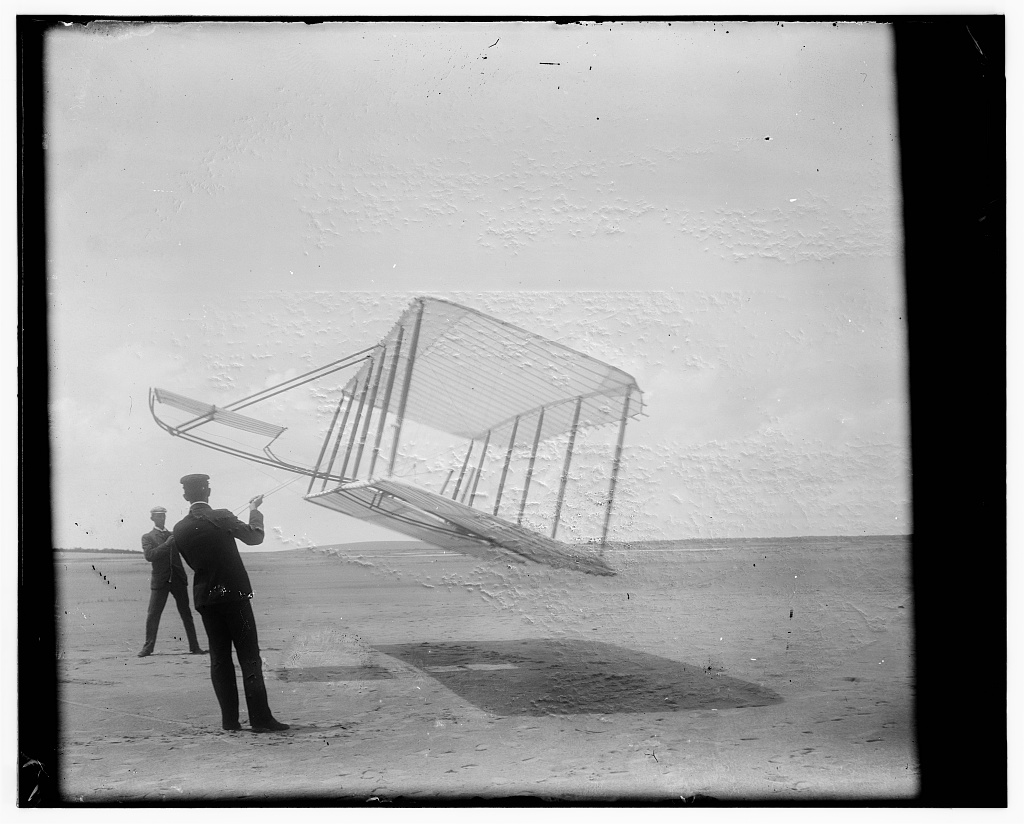

In [75]:
with open('image.jpg', 'wb') as img:
  for chunk in r.iter_content(chunk_size=128):
      img.write(chunk)

Image(filename='image.jpg')

Our image is displayed. But we came here to look for a way to use the IIIF or determine if the images are supporetd by IIIF. Sadly this collection is not. The image URLs are the key detail in our investigation.

if an image is supported by IIIF it will have a url similar to -
[https://tile.loc.gov/image-services/iiif/service:sgp:sgpbatches:batch_dlc_anacostia_ver01:data:sn84025948:0023728866A:1942081001:0202/full/full/0/default.jpg](https://tile.loc.gov/image-services/iiif/service:sgp:sgpbatches:batch_dlc_anacostia_ver01:data:sn84025948:0023728866A:1942081001:0202/full/full/0/default.jpg)


### Lets write a fucntion that will determine based on the image URL of the items in the collection if it is supported by IIIF.

In [76]:
def iiif_support(url):
    '''
    Determines if a collection has images that are supported by IIIF and how many
    '''
    items = get_image_urls(url, items=[])
    counter = Counter()

    for url in items:
      if "/iiif/" in url:
        counter['supported'] += 1
      else:
        counter['unsupported'] += 1

    support = pd.Series(counter)
    support.sort_values(ascending=True).plot(kind='barh', figsize=(9,9))

    return

getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=2
getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=3
getting next page: https://www.loc.gov/collections/wright-brothers-negatives/?c=100&fo=json&sp=4


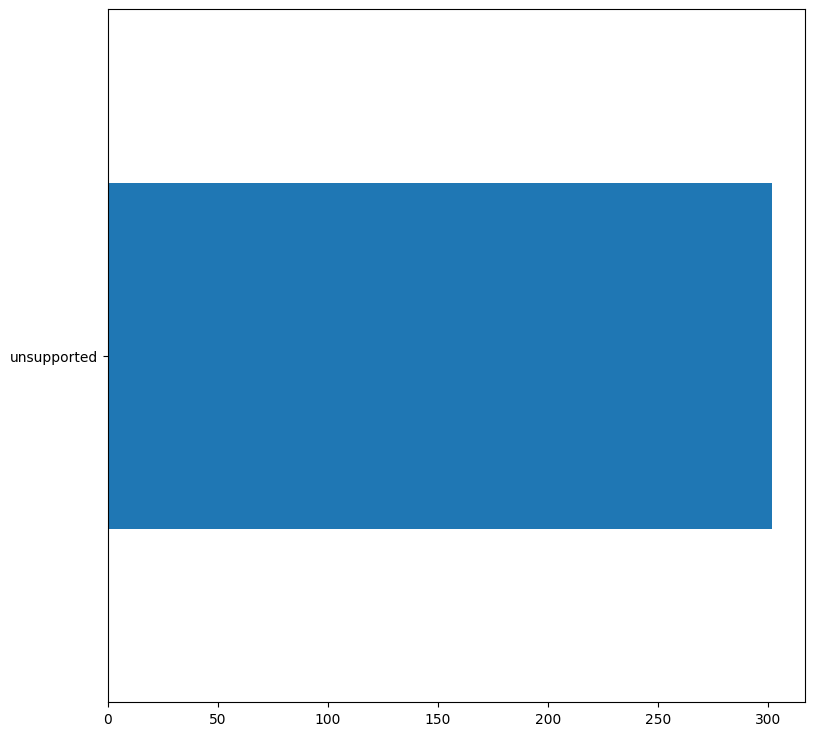

In [77]:
iiif_support('https://www.loc.gov/collections/wright-brothers-negatives')

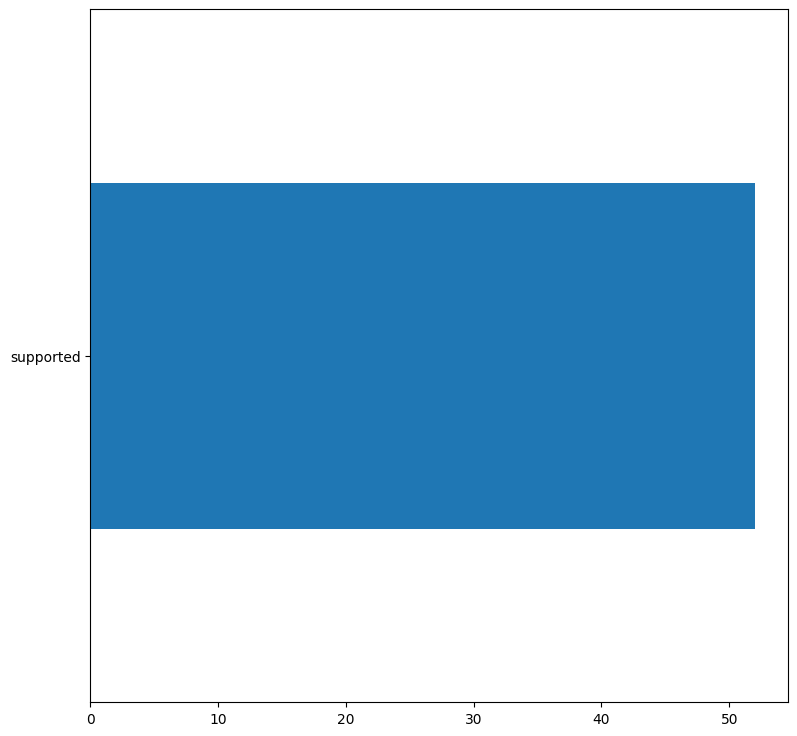

In [79]:
iiif_support('https://www.loc.gov/collections/tenth-to-sixteenth-century-liturgical-chants/')

We found one that is supported, lets look at the links

In [80]:
image_urls = get_image_urls("https://www.loc.gov/collections/tenth-to-sixteenth-century-liturgical-chants/", items=[])
image_urls

['https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100038:musemnotation-100038.0001/full/pct:100/0/default.jpg#h=5638&w=4153',
 'https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100032:musemnotation-100032.0001/full/pct:100/0/default.jpg#h=4860&w=3525',
 'https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100031:musemnotation-100031.0001/full/pct:100/0/default.jpg#h=5225&w=3570',
 'https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100039:musemnotation-100039.0001/full/pct:100/0/default.jpg#h=2997&w=3623',
 'https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100041:musemnotation-100041.0001/full/pct:100/0/default.jpg#h=3771&w=6568',
 'https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100027:musemnotation-100027.0001/full/pct:100/0/default.jpg#h=4720&w=3439',
 'https://tile.loc.gov/image-servi

### Lets request an image and display it

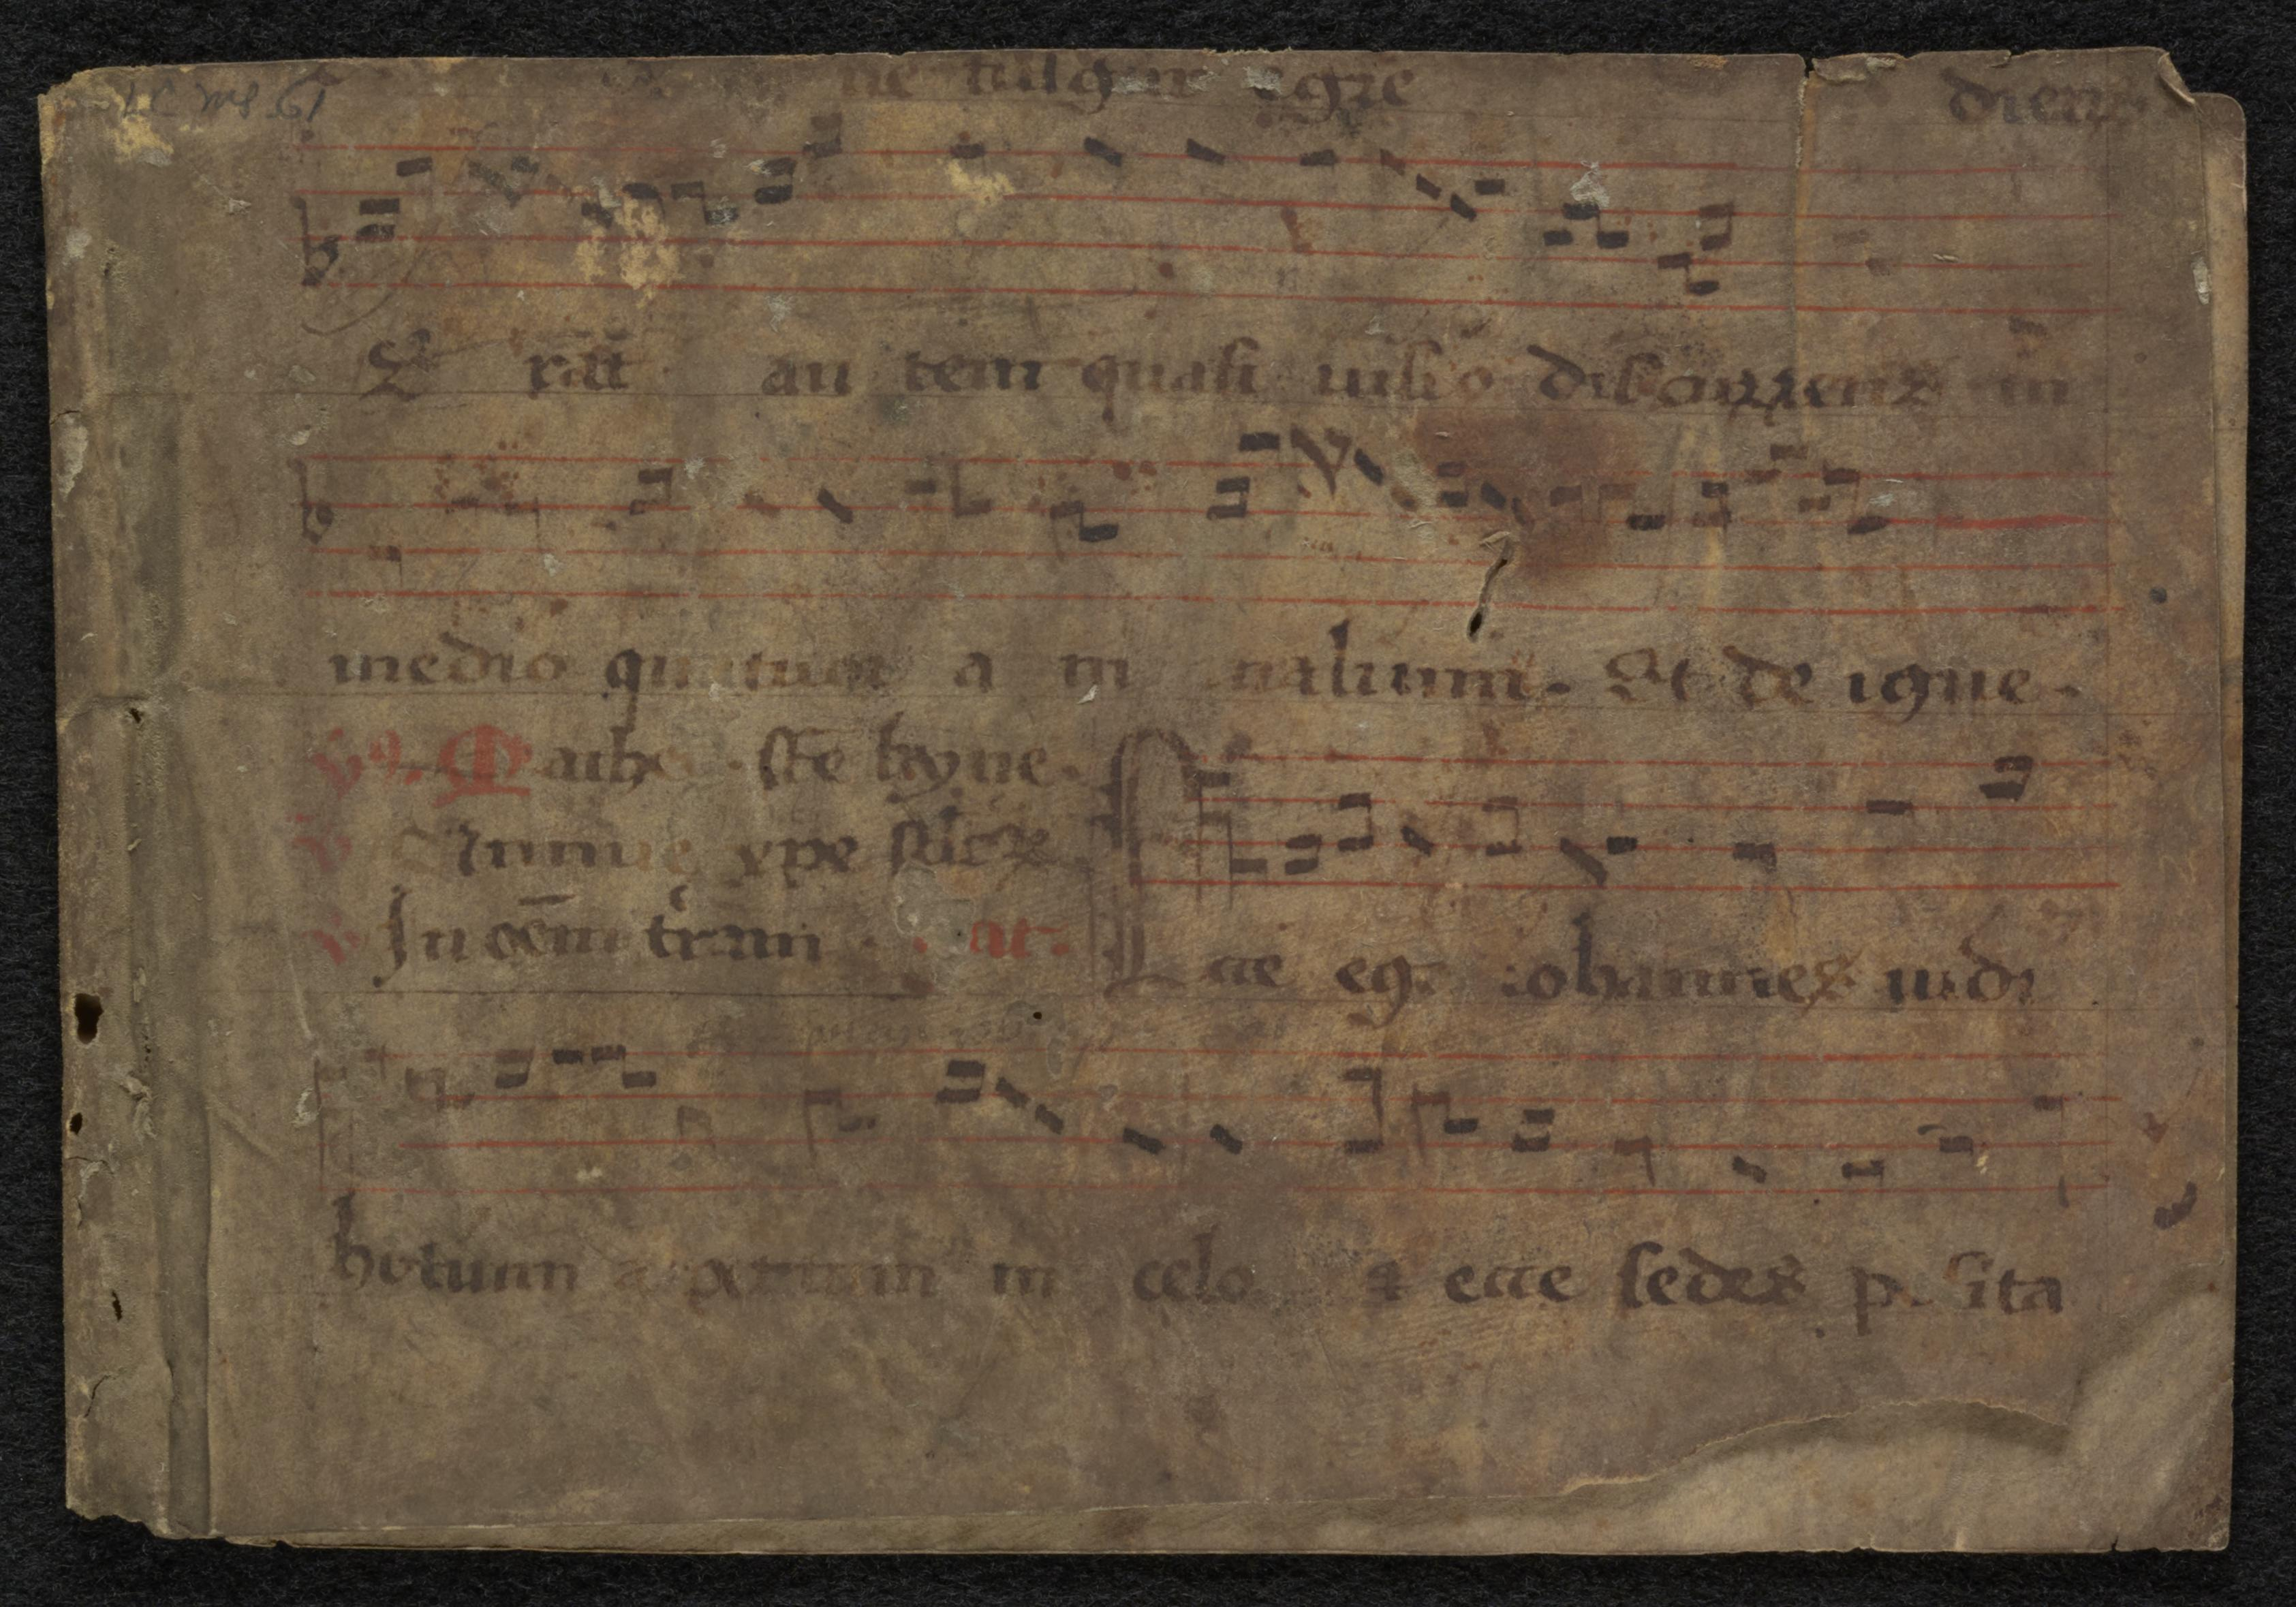

In [89]:
r = requests.get(image_urls[25] , stream = True)
with open('image.jpg', 'wb') as img:
  for chunk in r.iter_content(chunk_size=128):
      img.write(chunk)

Image(filename='image.jpg')



### Now we will use IIIF to maniplate the image but first lets see what it supports.



In [91]:
stuff = image_urls[25].split("/full")
url = stuff[0] + "/info.json"
print(url)
r = requests.get("http://tile.loc.gov/image-services/iiif/service:sgp:sgpbatches:batch_dlc_anacostia_ver01:data:sn84025948:0023728866A:1942081001:0202/info.json")
r.json()

https://tile.loc.gov/image-services/iiif/service:music:musemnotation:musemnotation-100046:musemnotation-100046-0001/info.json


{'@context': 'http://iiif.io/api/image/2/context.json',
 '@id': 'https://tile.loc.gov/image-services/iiif/service:sgp:sgpbatches:batch_dlc_anacostia_ver01:data:sn84025948:0023728866A:1942081001:0202',
 'protocol': 'http://iiif.io/api/image',
 'height': 4663,
 'width': 3156,
 'tiles': [{'width': 512, 'scaleFactors': [1, 2, 4, 8, 16, 32]}],
 'profile': ['http://iiif.io/api/image/2/level2.json',
  {'formats': ['jpg', 'txt', 'jp2', 'tif', 'pdf', 'gif', 'png', 'webp'],
   'qualities': ['default', 'native', 'color', 'gray', 'bitonal'],
   'supports': ['baseUriRedirect',
    'cors',
    'jsonldMediaType',
    'mirroring',
    'regionByPct',
    'regionByPx',
    'rotationBy90s',
    'sizeByWhListed',
    'sizeByForcedWh',
    'sizeByH',
    'sizeByPct',
    'sizeByW',
    'sizeByWh']}]}

### Lets request a region of the image

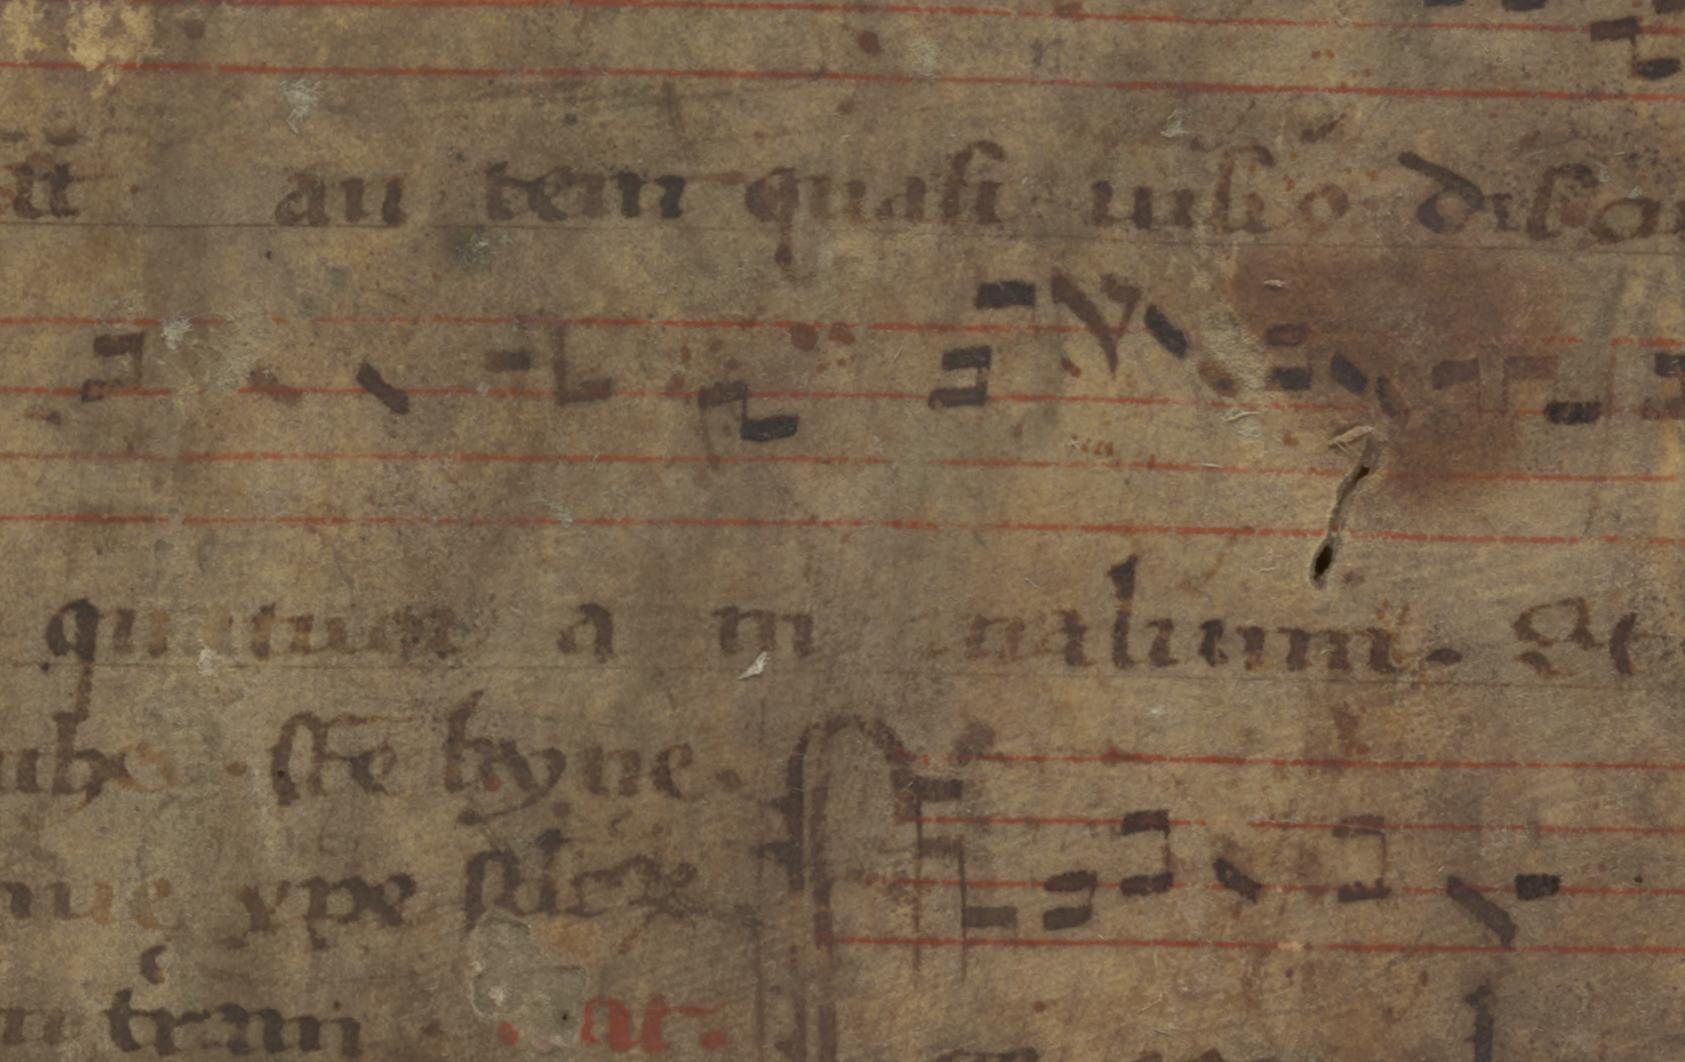

In [95]:
r = requests.get(stuff[0] + "/pct:25,15,50,45/full/0/default.jpg" , stream = True)
with open('image.jpg', 'wb') as img:
  for chunk in r.iter_content(chunk_size=128):
      img.write(chunk)
Image(filename='image.jpg')